In [1]:
import math
import random

import gymnasium as gym
import imageio
import numpy as np
from mad_pod_racing import MapPodRacing

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Categorical
from IPython.display import clear_output
import matplotlib.pyplot as plt

C:\Users\boris\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
gym.register(
        id="gymnasium_env/MapPodRacing-v0",
        entry_point=MapPodRacing,
        max_episode_steps=500,  # Prevent infinite episodes
)

env_name = 'gymnasium_env/MapPodRacing-v0'
env = gym.make(env_name)

In [3]:
class RL(nn.Module):
    def __init__(self, action_num=8, hidden_size=64):
        super(RL, self).__init__()
        self.fc_actor1 = nn.Linear(8, hidden_size)
        self.fc_actor2 = nn.Linear(hidden_size, hidden_size)
        self.fc_actor3 = nn.Linear(hidden_size, action_num)

        self.fc_critic1 = nn.Linear(8, hidden_size)
        self.fc_critic2 = nn.Linear(hidden_size, hidden_size)
        self.fc_critic3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        ax = F.relu(self.fc_actor1(x))
        ax2 = F.relu(self.fc_actor2(ax))
        dist = Categorical(logits = self.fc_actor3(ax2))
                   
        cx = F.relu(self.fc_critic1(x))
        cx2 = F.relu(self.fc_critic2(cx))
        value = self.fc_critic3(cx2)
        return dist, value

In [4]:
def calc_returns(rewards, gamma = 0.99):
    returns = []
    delta = 0
    for reward in rewards[::-1]:
        #Bug fixed on this line
        delta = reward + gamma*delta
        returns.insert(0, delta)
    return returns

def test_agent():
    terminated = False
    total_reward = 0
    obs,info = env.reset()
    observation = torch.FloatTensor(obs).unsqueeze(0)

    with torch.no_grad():
        while not terminated:
            dist, _ = rl_model(observation)
            action = dist.sample().cpu().item()
            observation, reward, terminated, truncated, info = env.step(action)
            
            observation = torch.FloatTensor(observation).unsqueeze(0)
            total_reward += reward
            
    return total_reward

In [5]:
rl_model = RL()
lr = 1e-1
optimizer = optim.Adam(rl_model.parameters(), lr=lr)

In [6]:
max_steps = 500000
rollouts = 0
step = 0
score_logger = []
epsilon = 0.3

In [7]:
while step < max_steps:
    obs,info = env.reset()
    observation =  torch.FloatTensor(obs).unsqueeze(0)
    terminated = False
    rewards = []
    values = []
    log_probs = []
    
    while not terminated:
        dist, value = rl_model(observation)
        z = random.random()
        if z >= epsilon:
            action = dist.sample()
        else:
            action = torch.tensor([random.randint(0, 7)])

        log_prob = dist.log_prob(action.unsqueeze(0))
        
        observation, reward, terminated, truncated, info = env.step(action.cpu().item())

        observation = torch.FloatTensor(observation).unsqueeze(0)
        reward = torch.FloatTensor([reward]).unsqueeze(0)

        rewards.append(reward)
        values.append(value)
        log_probs.append(log_prob)
        step +=1
    
    returns = calc_returns(rewards)
    
    returns = torch.cat(returns, 1)
    log_probs = torch.cat(log_probs, 1)
    values = torch.cat(values, 1)
    advantage = (returns - values).detach()
    
    action_loss = - (log_probs * advantage).mean()
    critic_loss = (returns - values).pow(2).mean()
    agent_loss = action_loss + critic_loss
    
    optimizer.zero_grad()
    agent_loss.backward()
    optimizer.step()
    rollouts += 1
    
    if rollouts % 10 == 0:
        new_lr = ((max_steps - step)/max_steps) * lr
        optimizer.param_groups[0]["lr"] = new_lr
        
        score_logger.append(np.mean([test_agent() for _ in range(10)]))
        clear_output(True)
        plt.plot(score_logger)
        plt.show()
    
env.close()

terminated = False
total_reward = 0
obs,info = env.reset()
observation = torch.FloatTensor(obs).unsqueeze(0)
frames = [env.render()]
round =0
with torch.no_grad():
    while not terminated:
        round +=1
        dist, _ = rl_model(observation)
        action = dist.sample().cpu().item()
        observation, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        observation = torch.FloatTensor(observation).unsqueeze(0)
        total_reward += reward
print(total_reward)
print(round)
imageio.mimsave("mad_pod_episode.gif", frames, fps=10)


-25.300000000000004
22


In [8]:
value

tensor([[-14.9607]], grad_fn=<AddmmBackward0>)

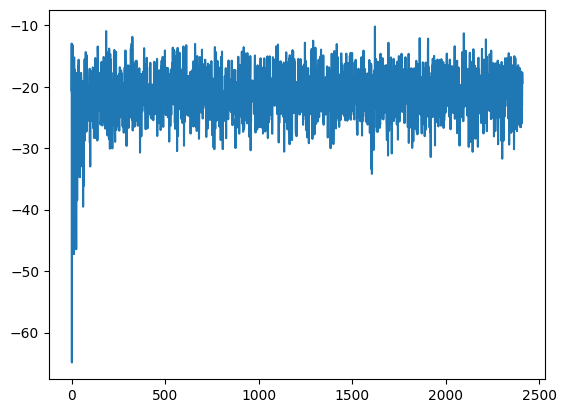

In [9]:
plt.plot(score_logger)

In [33]:
terminated = False
total_reward = 0
obs,info = env.reset()
observation = torch.FloatTensor(obs).unsqueeze(0)
frames = [env.render()]
round =0
with torch.no_grad():
    while not terminated:
        round +=1
        dist, _ = rl_model(observation)
        action = dist.sample().cpu().item()
        observation, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        observation = torch.FloatTensor(observation).unsqueeze(0)
        total_reward += reward
print(total_reward)
print(round)
imageio.mimsave("mad_pod_episode.gif", frames, fps=10)

-24.1
28
